# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from google.colab import drive
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/seaside_house_pred.csv', sep=';', index_col=0)

# Dataset Exploration

In [ ]:
df.columns

Index(['HOUSING_MEDIAN_AGE', 'TOTAL_ROOMS', 'TOTAL_BEDROOMS', 'POPULATION',
       'HOUSEHOLDS', 'MEDIAN_INCOME', 'MEDIAN_HOUSE_VALUE', 'MOISTURE_LEVEL',
       'MEDIAN_FLOOR_COUNT', 'TARGET', 'ARCHITECTURAL_STYLE',
       'COMMUNITY_ENGAGEMENT'],
      dtype='object')

In [ ]:
df.columns = [col.lower() for col in df.columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20635 entries, 0 to 20634
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   housing_median_age    20635 non-null  float64
 1   total_rooms           20635 non-null  float64
 2   total_bedrooms        20428 non-null  float64
 3   population            20635 non-null  float64
 4   households            11312 non-null  float64
 5   median_income         20635 non-null  float64
 6   median_house_value    20635 non-null  float64
 7   moisture_level        20635 non-null  int64  
 8   median_floor_count    20635 non-null  float64
 9   target                20635 non-null  float64
 10  architectural_style   18572 non-null  object 
 11  community_engagement  16508 non-null  object 
dtypes: float64(9), int64(1), object(2)
memory usage: 2.0+ MB


In [ ]:
df.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,moisture_level,median_floor_count,target,architectural_style,community_engagement
ID,,,,,,,,,,,,
0,24.0,3305.0,982.0,2085.0,881.0,2.6641,168200.0,17,1.33,0.0,NaN,low
1,26.0,2145.0,369.0,1285.0,377.0,4.9464,223800.0,78,1.39,1.0,Colonial,medium
2,52.0,2113.0,332.0,800.0,327.0,11.1768,500001.0,79,1.18,0.0,Contemporary,medium
3,35.0,2828.0,487.0,1439.0,490.0,5.6013,350200.0,30,1.27,0.0,Contemporary,high
4,21.0,3764.0,1081.0,1919.0,NaN,2.5057,156300.0,32,1.11,0.0,Colonial,high


# Exploratory Data Analysis

In [ ]:
df.describe()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,moisture_level,median_floor_count,target
count,20635.000000,20635.000000,20428.000000,20635.000000,11312.000000,20635.000000,20635.000000,20635.000000,20635.000000,20635.000000
mean,28.636152,2636.020208,537.899305,1425.660286,504.329120,3.870944,206813.756288,47.251708,1.312169,0.239787
std,12.583924,2181.794772,421.425970,1132.530137,392.380603,1.899961,115372.499511,25.600932,0.219212,0.426964
min,1.000000,2.000000,1.000000,3.000000,2.000000,0.499900,14999.000000,0.000000,1.000000,0.000000
25%,18.000000,1448.000000,296.000000,787.000000,282.000000,2.563100,119600.000000,26.000000,1.140000,0.000000
50%,29.000000,2127.000000,435.000000,1166.000000,412.000000,3.535200,179700.000000,49.000000,1.290000,0.000000
75%,37.000000,3148.000000,647.000000,1725.000000,609.000000,4.743700,264700.000000,68.000000,1.430000,0.000000
max,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,100.000000,2.000000,1.000000


## Univariate Data Exploration

### Target Variable

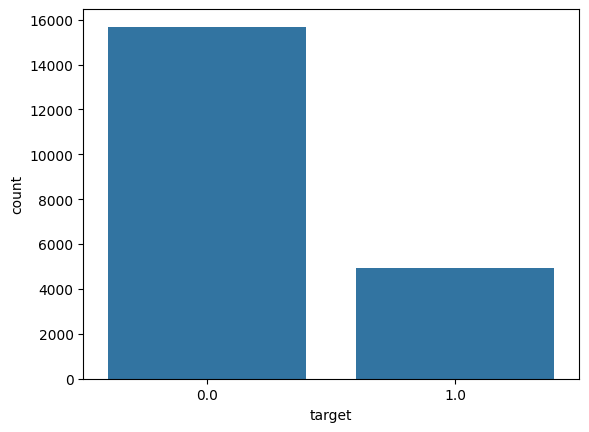

In [ ]:
sns.countplot(data=df, x='target');

The target variable suffers from imbalanced data. We will address this issue before training our model using resampling techniques.

### Continuous Variables

In [ ]:
cont_vars = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households',
             'median_income', 'median_house_value', 'moisture_level', 'median_floor_count']

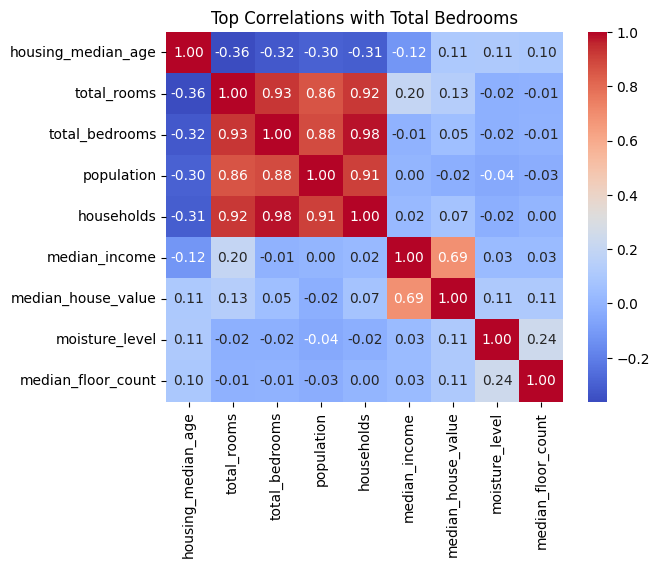

In [ ]:
sns.heatmap(df[cont_vars].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Top Correlations with Total Bedrooms')
plt.show();

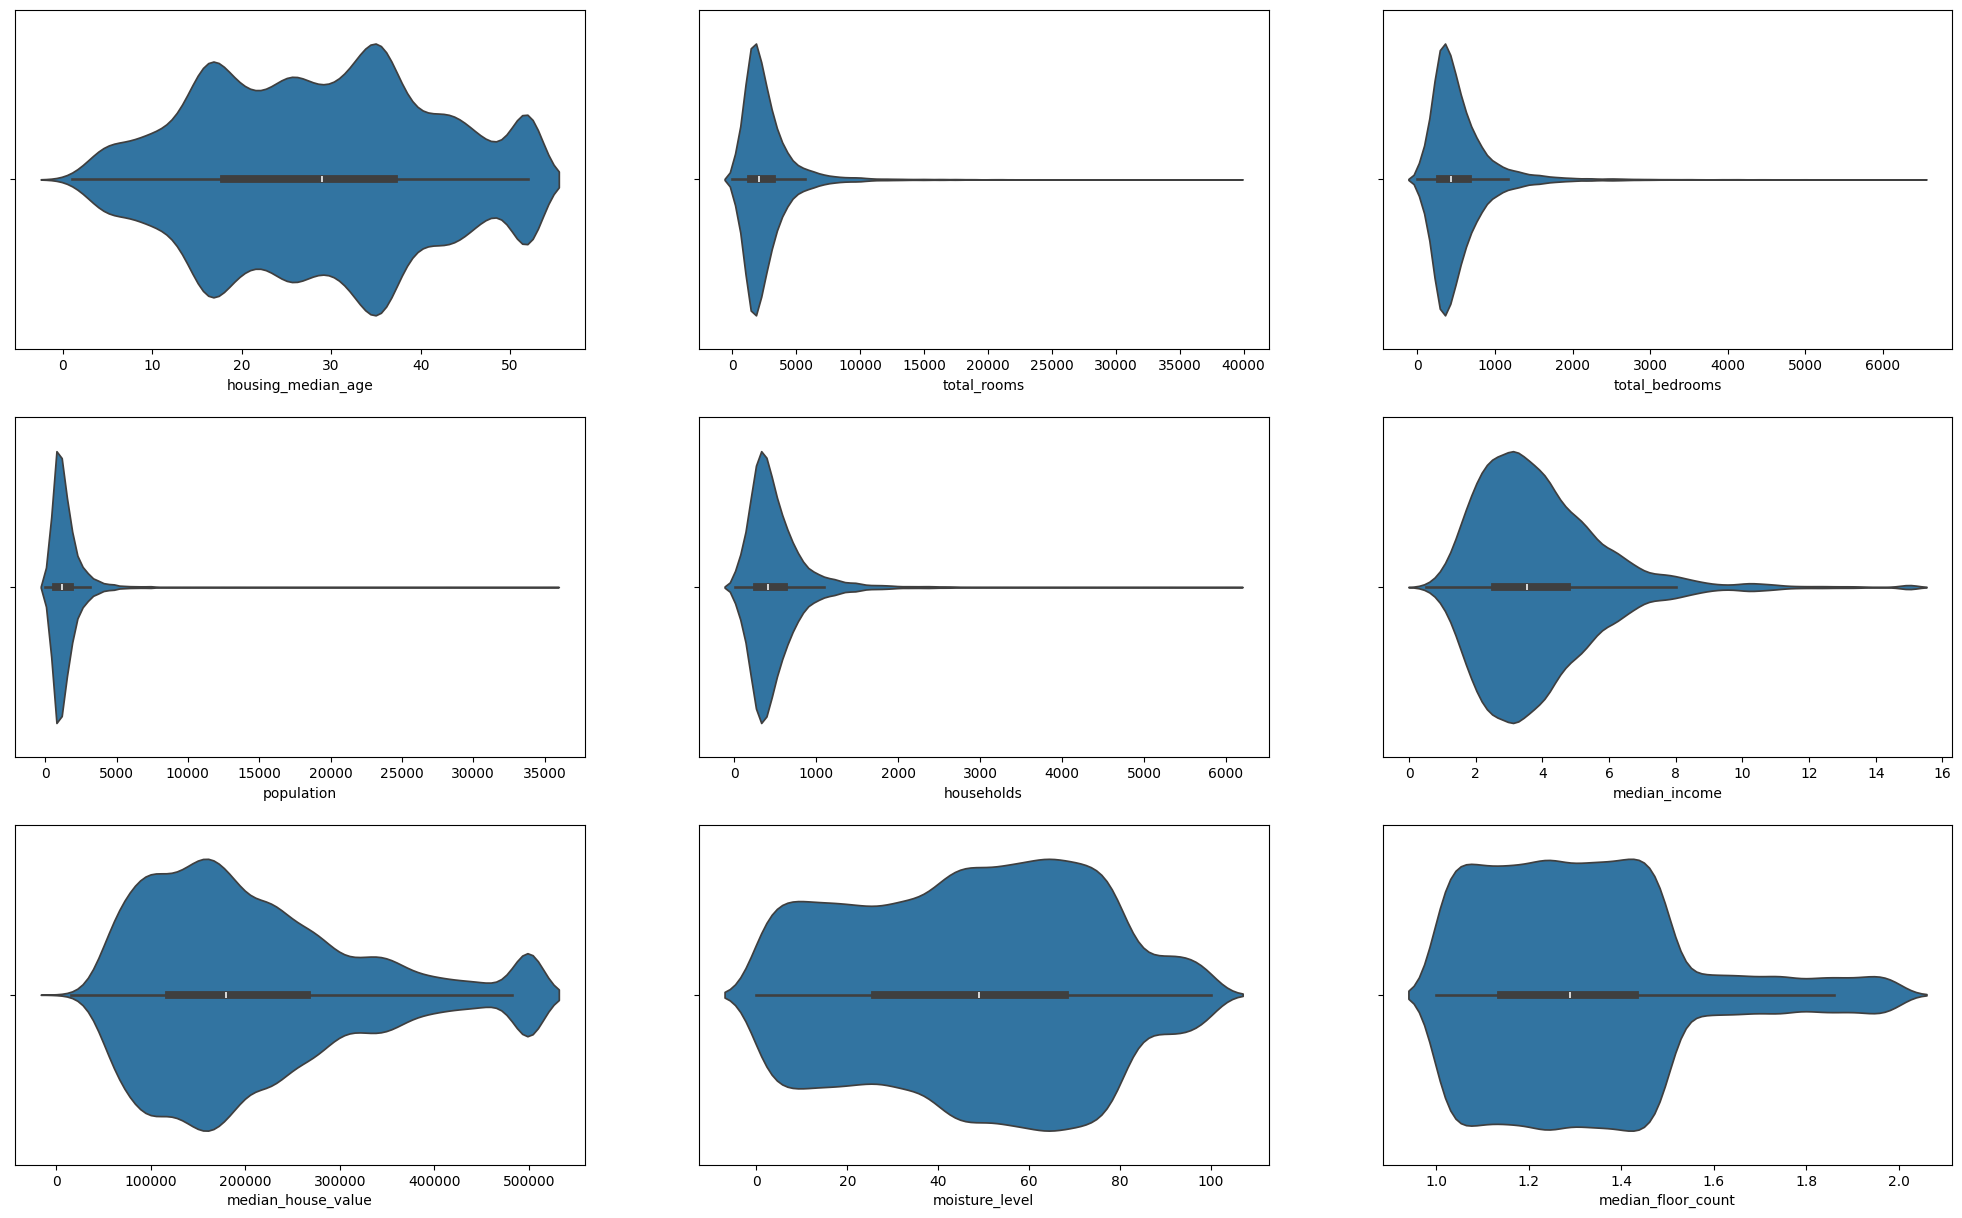

In [ ]:
fig, ax = plt.subplots(nrows=3,ncols=3, figsize=(25,15))
for i, col in enumerate(cont_vars):
  if i<3:
    sns.violinplot(data=df,
                  x=col,
                  density_norm='count',
                  ax=ax[0,i])
  elif i<6:
    sns.violinplot(data=df,
                  x=col,
                  density_norm='count',
                  ax=ax[1,i-3])
  else:
    sns.violinplot(data=df,
                  x=col,
                  density_norm='count',
                  ax=ax[2,i-6]);

Some features suffer from extreme outliers. Some noise reduction may be required. Let's take a look at each feature one by one:

#### housing_median_age

In [ ]:
df['housing_median_age'].describe(percentiles=np.arange(0,1,0.1))

count    20635.000000
mean        28.636152
std         12.583924
min          1.000000
0%           1.000000
10%         13.000000
20%         17.000000
30%         20.000000
40%         25.000000
50%         29.000000
60%         33.000000
70%         36.000000
80%         40.000000
90%         46.000000
max         52.000000
Name: housing_median_age, dtype: float64

The distribution looks natural, and the skewness is not extreme. A transformation is not necessary.

#### total_rooms

In [ ]:
df['total_rooms'].describe(percentiles=np.arange(0,1,0.05))

count    20635.000000
mean      2636.020208
std       2181.794772
min          2.000000
0%           2.000000
5%         620.700000
10%        941.000000
15%       1143.000000
20%       1298.000000
25%       1448.000000
30%       1578.200000
35%       1709.000000
40%       1835.000000
45%       1983.000000
50%       2127.000000
55%       2287.000000
60%       2462.000000
65%       2657.000000
70%       2876.000000
75%       3148.000000
80%       3485.200000
85%       3942.000000
90%       4654.000000
95%       6214.200000
max      39320.000000
Name: total_rooms, dtype: float64

95% of the observations have less than 6214 total rooms. However, the distribution of data points is extremely skewed, with significant outliers. How we deal with the largest values is very important.

In [ ]:
quantiles = np.arange(0.95,1,0.01)
for i, quantile in enumerate(quantiles):
  print(f"quantile {0.95+i/100} =", df.total_rooms.quantile(quantile))

quantile 0.95 = 6214.199999999997
quantile 0.96 = 6739.639999999999
quantile 0.97 = 7504.859999999997
quantile 0.98 = 8855.119999999995
quantile 0.99 = 11214.659999999993
quantile 1.0 = 39320.0


We see a big amount of increase from the 99th percentile to the maximum value.

In [ ]:
df.total_rooms.nlargest(10)

ID
13216    39320.0
6093     37937.0
5072     32627.0
17056    32054.0
20296    30450.0
13285    30405.0
520      30401.0
8365     28258.0
7623     27870.0
3767     27700.0
Name: total_rooms, dtype: float64

Let's see the proportion of outliers:

In [ ]:
IQR = df.total_rooms.quantile(0.75) - df.total_rooms.quantile(0.25) # Interquartile range
UB = df.total_rooms.quantile(0.75) + 1.5*IQR
LB = max(df.total_rooms.quantile(0.25) - 1.5*IQR, 0) # Since it cannot be negative
print(f"The lower bound for outliers is: {LB}")
print(f"The upper bound for outliers is: {UB}")

outlier_count = len(df[(df.total_rooms > UB) | (df.total_rooms < LB)])
print(f"Proportion of outliers is: {outlier_count/len(df)}")

The lower bound for outliers is: 0
The upper bound for outliers is: 5698.0
Proportion of outliers is: 0.062369760116307245


The outliers don't seem to be wrong observations, but they indeed make up a relatively big portion of the dataset, more than 6%. We can reduce the impact of outliers by performing log transformation before fitting the model.

#### total_bedrooms

In [ ]:
df.total_bedrooms.isna().sum()

207

There are 207 missing observations regarding total_bedrooms. We are possibly going to impute them. Since it is highly correlated with total_rooms and population, we are going to prioritize them for our imputation.

In [ ]:
df['total_bedrooms'].describe(percentiles=np.arange(0,1,0.05))

count    20428.000000
mean       537.899305
std        421.425970
min          1.000000
0%           1.000000
5%         137.000000
10%        198.000000
15%        238.000000
20%        270.000000
25%        296.000000
30%        322.100000
35%        349.000000
40%        377.000000
45%        406.000000
50%        435.000000
55%        468.000000
60%        502.000000
65%        544.000000
70%        591.000000
75%        647.000000
80%        719.000000
85%        812.000000
90%        965.000000
95%       1275.650000
max       6445.000000
Name: total_bedrooms, dtype: float64

In [ ]:
df.total_bedrooms.nlargest(20)

ID
5072     6445.0
13216    6210.0
6093     5471.0
17067    5419.0
17056    5290.0
20296    5033.0
7623     5027.0
520      4957.0
6467     4952.0
19932    4819.0
2222     4798.0
19976    4585.0
16740    4522.0
968      4492.0
15761    4457.0
7638     4407.0
4611     4386.0
9915     4335.0
2341     4183.0
3767     4179.0
Name: total_bedrooms, dtype: float64

In [ ]:
IQR = df.total_bedrooms.quantile(0.75)-df.total_bedrooms.quantile(0.25)
UB = df.total_bedrooms.quantile(0.75) + 1.5*IQR
LB = max(df.total_bedrooms.quantile(0.25) - 1.5*IQR, 0) # Since it cannot be negative
print(f"The lower bound for outliers is: {LB}")
print(f"The upper bound for outliers is: {UB}")

outlier_count = len(df[(df.total_bedrooms > UB) | (df.total_bedrooms < LB)])
print(f"Proportion of outliers is: {outlier_count/len(df)}")

The lower bound for outliers is: 0
The upper bound for outliers is: 1173.5
Proportion of outliers is: 0.06159437848315968


Following the same thought process as total_rooms, we are better off transforming total_bedrooms as well.

#### population

In [ ]:
df['population'].describe(percentiles=np.arange(0,1,0.05))

count    20635.000000
mean      1425.660286
std       1132.530137
min          3.000000
0%           3.000000
5%         348.000000
10%        510.400000
15%        622.000000
20%        710.000000
25%        787.000000
30%        859.000000
35%        933.000000
40%       1007.000000
45%       1086.000000
50%       1166.000000
55%       1255.000000
60%       1349.000000
65%       1460.100000
70%       1580.000000
75%       1725.000000
80%       1908.000000
85%       2153.000000
90%       2566.000000
95%       3288.000000
max      35682.000000
Name: population, dtype: float64

<Axes: ylabel='population'>

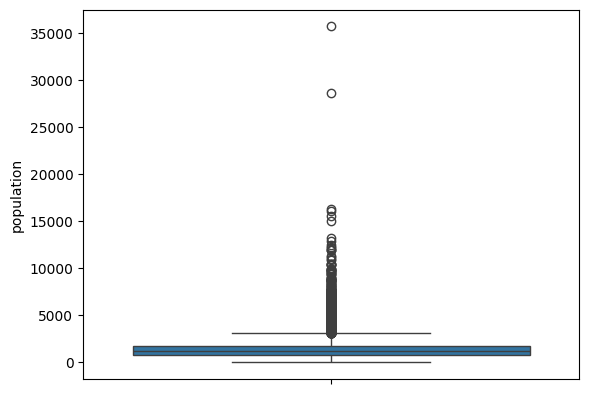

In [ ]:
sns.boxplot(y=df.population)

In [ ]:
df.population.nlargest(10)

ID
19932    35682.0
5072     28566.0
13216    16305.0
6093     16122.0
17056    15507.0
3767     15037.0
520      13251.0
13285    12873.0
16211    12427.0
8365     12203.0
Name: population, dtype: float64

In [ ]:
IQR = df.population.quantile(0.75)-df.population.quantile(0.25)
UB = df.population.quantile(0.75) + 1.5*IQR
LB = max(df.population.quantile(0.25) - 1.5*IQR, 0) # Since it cannot be negative
print(f"The lower bound for outliers is: {LB}")
print(f"The upper bound for outliers is: {UB}")

outlier_count = len(df[(df.population > UB) | (df.population < LB)])
print(f"Proportion of outliers is: {outlier_count/len(df)}")

The lower bound for outliers is: 0
The upper bound for outliers is: 3132.0
Proportion of outliers is: 0.05795977707778047


In this case, we have two observations that are significantly larger than the 3rd largest observation. While I'll deal with the rest of the outliers through transformation, I'll likely drop the two highest observations in population as they are very uncommon anyway.

#### households

In [ ]:
df.households.isna().mean()

0.4518051853646717

About 45% of the data is missing for this variable. Too much information is missing, imputing the data will likely result in biased predictions. We are better off dropping this column.

In [ ]:
df.drop(['households'], axis=1, inplace=True)

#### median_income

In [ ]:
df['median_income'].describe(percentiles=np.arange(0,1,0.05))

count    20635.000000
mean         3.870944
std          1.899961
min          0.499900
0%           0.499900
5%           1.600420
10%          1.903800
15%          2.148400
20%          2.352300
25%          2.563100
30%          2.740500
35%          2.966200
40%          3.140600
45%          3.319120
50%          3.535200
55%          3.721340
60%          3.967640
65%          4.171120
70%          4.437500
75%          4.743700
80%          5.109820
85%          5.542990
90%          6.159260
95%          7.300330
max         15.000100
Name: median_income, dtype: float64

In [ ]:
IQR = df.median_income.quantile(0.75)-df.median_income.quantile(0.25)
UB = df.median_income.quantile(0.75) + 1.5 * IQR
LB = max(df.median_income.quantile(0.25) - 1.5 * IQR, 0) # Since it cannot be negative
print(f"The lower bound for outliers is: {LB}")
print(f"The upper bound for outliers is: {UB}")

outlier_count = len(df[(df.median_income > UB) | (df.median_income < LB)])
print(f"Proportion of outliers is: {outlier_count/len(df)}")

The lower bound for outliers is: 0
The upper bound for outliers is: 8.014599999999998
Proportion of outliers is: 0.032905258056699783


In [ ]:
df.median_income.nlargest(10)

ID
964     15.0001
1735    15.0001
1851    15.0001
2020    15.0001
2052    15.0001
2091    15.0001
2148    15.0001
2190    15.0001
2251    15.0001
2361    15.0001
Name: median_income, dtype: float64

In [ ]:
df[df.median_income == df.median_income.max()].head(10)

,housing_median_age,total_rooms,total_bedrooms,population,median_income,median_house_value,moisture_level,median_floor_count,target,architectural_style,community_engagement
ID,,,,,,,,,,,
964,48.0,1371.0,NaN,528.0,15.0001,500001.0,54,1.34,0.0,Modern,NaN
1735,37.0,407.0,67.0,100.0,15.0001,500001.0,68,1.06,0.0,Modern,NaN
1851,52.0,220.0,32.0,55.0,15.0001,131300.0,0,1.38,0.0,Modern,medium
2020,52.0,955.0,100.0,457.0,15.0001,500001.0,65,1.10,0.0,Mediterranean,low
2052,52.0,1841.0,240.0,693.0,15.0001,500001.0,35,1.01,0.0,Victorian,high
2091,46.0,778.0,90.0,238.0,15.0001,500001.0,40,1.30,0.0,Contemporary,low
2148,40.0,2529.0,293.0,831.0,15.0001,500001.0,46,1.62,1.0,Victorian,low
2190,42.0,2861.0,360.0,829.0,15.0001,500001.0,5,1.01,0.0,Colonial,medium
2251,52.0,3815.0,439.0,1266.0,15.0001,500001.0,22,1.25,0.0,Contemporary,low


In [ ]:
df.median_income.value_counts() #49 observations at the highest level.

median_income
3.1250     49
15.0001    49
2.8750     46
2.6250     44
4.1250     44
           ..
0.9889      1
2.5553      1
7.3719      1
5.0150      1
5.5551      1
Name: count, Length: 12927, dtype: int64

In [ ]:
df.median_income.describe(percentiles=np.arange(0,1,0.1))

count    20635.000000
mean         3.870944
std          1.899961
min          0.499900
0%           0.499900
10%          1.903800
20%          2.352300
30%          2.740500
40%          3.140600
50%          3.535200
60%          3.967640
70%          4.437500
80%          5.109820
90%          6.159260
max         15.000100
Name: median_income, dtype: float64

In [ ]:
quantiles = np.arange(0.95,1,0.01)
for i, quantile in enumerate(quantiles):
  print(f"quantile {0.95+i/100} =", df.median_income.quantile(quantile))

quantile 0.95 = 7.30033
quantile 0.96 = 7.7197
quantile 0.97 = 8.161069999999999
quantile 0.98 = 8.947999999999997
quantile 0.99 = 10.596739999999999
quantile 1.0 = 15.0001


An interesting thing is there are a lot of entries with the largest observation (15.0001). This repetition at a high level might be due to data entry errors or the column being capped at the value 15.0001. We don't know if the data is capped due to a data collection policy or other legitimate reason, therefore to avoid skewing our analysis results, I am going to drop them. We could also perform a separate analysis if we knew more about the data collection policy.

In [ ]:
df_dropped = df[df.median_income != 15.0001]

In [ ]:
df_dropped['income_bin'] = pd.qcut(df_dropped['median_income'], q=20, labels=False, duplicates='drop')

<ipython-input-1455-ac801693bc2c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropped['income_bin'] = pd.qcut(df_dropped['median_income'], q=20, labels=False, duplicates='drop')


Visualizing the proportion of houses with seaside based on income bins that are created through quantiles:

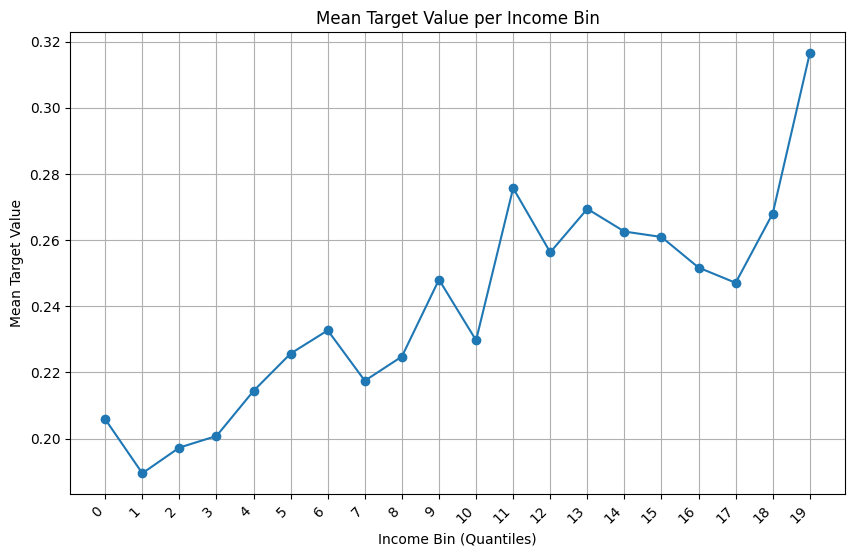

In [ ]:
mean_target_per_bin = df_dropped.groupby('income_bin')['target'].mean()

plt.figure(figsize=(10, 6))
plt.plot(mean_target_per_bin, marker='o')
plt.xlabel('Income Bin (Quantiles)')
plt.ylabel('Mean Target Value')
plt.title('Mean Target Value per Income Bin')
plt.grid(True)
plt.xticks(ticks=range(len(mean_target_per_bin)), rotation=45,ha='right')
plt.show()

#### median_house_value

In [ ]:
df['median_house_value'].describe(percentiles=np.arange(0,1,0.10))

count     20635.000000
mean     206813.756288
std      115372.499511
min       14999.000000
0%        14999.000000
10%       82300.000000
20%      107200.000000
30%      134000.000000
40%      157300.000000
50%      179700.000000
60%      209300.000000
70%      241900.000000
80%      289900.000000
90%      376200.000000
max      500001.000000
Name: median_house_value, dtype: float64

In [ ]:
IQR = df.median_house_value.quantile(0.75)-df.median_house_value.quantile(0.25)
UB = df.median_house_value.quantile(0.75) + 1.5 * IQR
LB = max(df.median_house_value.quantile(0.25) - 1.5 * IQR, 0) # Since it cannot be negative
print(f"The lower bound for outliers is: {LB}")
print(f"The upper bound for outliers is: {UB}")

outlier_count = len(df[(df.median_house_value > UB) | (df.median_house_value < LB)])
print(f"Proportion of outliers is: {outlier_count/len(df)}")

The lower bound for outliers is: 0
The upper bound for outliers is: 482350.0
Proportion of outliers is: 0.05190210806881512


<Axes: ylabel='median_house_value'>

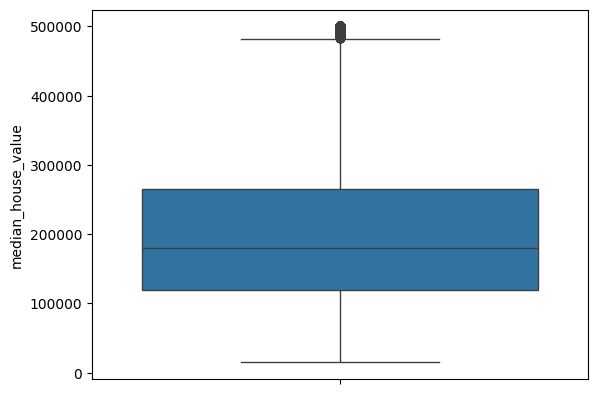

In [ ]:
sns.boxplot(data=df, y='median_house_value')

In [ ]:
df.median_house_value.value_counts().sort_index(ascending=False)

median_house_value
500001.0    965
500000.0     27
499100.0      1
499000.0      1
498800.0      1
           ... 
26600.0       1
25000.0       1
22500.0       4
17500.0       1
14999.0       4
Name: count, Length: 3842, dtype: int64

The repeated high value of 5000001 suggests that it is a capped value. Since it constitutes valuable information, I will not drop them, however knowing more about the collection of this data might help in understanding what to do (possibly performing a separate analysis on capped values).

moisture_level

In [ ]:
df.moisture_level.describe(percentiles=np.arange(0,1,0.1))

count    20635.000000
mean        47.251708
std         25.600932
min          0.000000
0%           0.000000
10%         10.000000
20%         21.000000
30%         32.000000
40%         41.000000
50%         49.000000
60%         57.000000
70%         64.000000
80%         71.000000
90%         79.000000
max        100.000000
Name: moisture_level, dtype: float64

In [ ]:
IQR = df.moisture_level.quantile(0.75)-df.moisture_level.quantile(0.25)
UB = df.moisture_level.quantile(0.75) + 1.5 * IQR
LB = max(df.moisture_level.quantile(0.25) - 1.5 * IQR, 0) # Since it cannot be negative
print(f"The lower bound for outliers is: {LB}")
print(f"The upper bound for outliers is: {UB}")

outlier_count = len(df[(df.moisture_level > UB) | (df.moisture_level < LB)])
print(f"Proportion of outliers is: {outlier_count/len(df)}")

The lower bound for outliers is: 0
The upper bound for outliers is: 131.0
Proportion of outliers is: 0.0


median_floor_count

In [ ]:
df.median_floor_count.describe(percentiles=np.arange(0,1,0.1))

count    20635.000000
mean         1.312169
std          0.219212
min          1.000000
0%           1.000000
10%          1.050000
20%          1.110000
30%          1.170000
40%          1.230000
50%          1.290000
60%          1.350000
70%          1.400000
80%          1.460000
90%          1.590000
max          2.000000
Name: median_floor_count, dtype: float64

### Categorical Variables

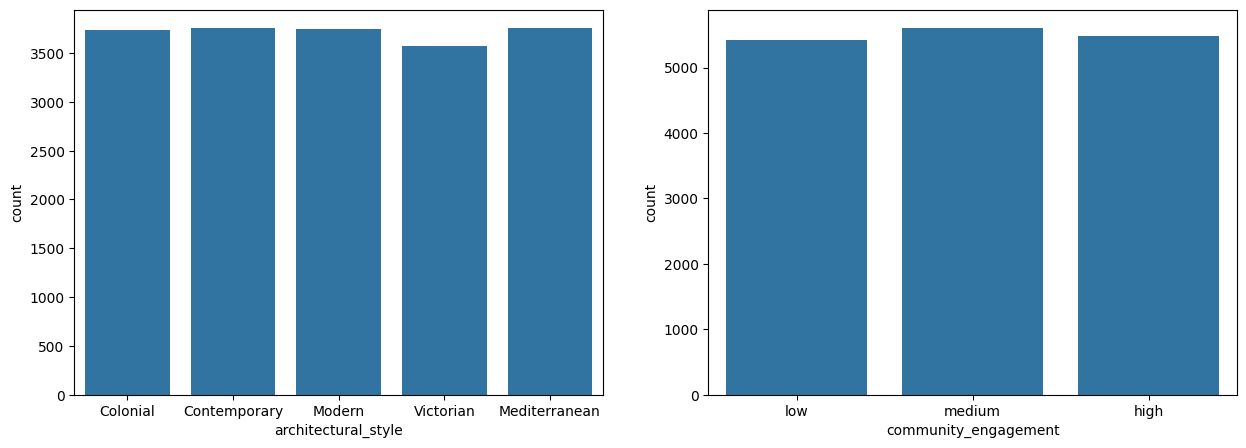

In [ ]:
dummy_vars = ['architectural_style', 'community_engagement']
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
for i, col in enumerate(dummy_vars):
  sns.countplot(data=df,
                x=col,
                ax=ax[i])

#### architectural_style

In [ ]:
df.architectural_style.value_counts()

architectural_style
Mediterranean    3757
Contemporary     3756
Modern           3750
Colonial         3735
Victorian        3574
Name: count, dtype: int64

In [ ]:
df.architectural_style.isna().sum()

2063

The houses are pretty evenly distributed across architectural styles, and we have a large enough sample size for each of them to be able to conduct an unbiased analysis. Around 10% of our data is missing. We can use KNN imputing to impute the rest, as architectural style might provide valuable information. However, it might be tricky for the imputer to accurately predict the achitectural style, therefore I will just handle them as a different dummy variable, Unknown.

In [ ]:
df['architectural_style'] = df['architectural_style'].fillna('Unknown_architecture')

#### community_engagement

In [ ]:
df.community_engagement.value_counts()

community_engagement
medium    5606
high      5476
low       5426
Name: count, dtype: int64

In [ ]:
df.community_engagement.isna().sum()

4127

Similar situation with community engagement, but instead we have around 20% of the data missing, and there clearly is an ordinal relationship. However, The features don't seem to impact our target variable, and imputing 20% of the data can be inaccurate. We are likely not going to use this feature.

In [ ]:
df['community_engagement'] = df['community_engagement'].fillna('Unknown_engagement')

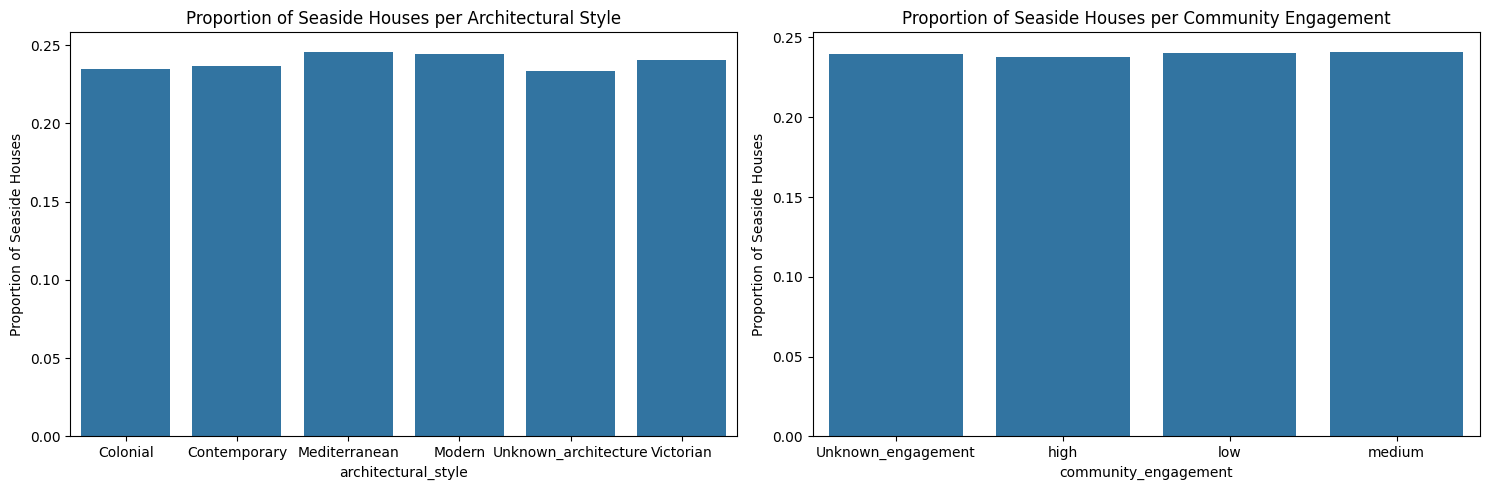

In [ ]:
arch_style_means = df.groupby('architectural_style')['target'].mean().reset_index()

comm_engagement_means = df.groupby('community_engagement')['target'].mean().reset_index()


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.barplot(data=arch_style_means, x='architectural_style', y='target', ax=ax[0])
ax[0].set_ylabel('Proportion of Seaside Houses')
ax[0].set_title('Proportion of Seaside Houses per Architectural Style')


sns.barplot(data=comm_engagement_means, x='community_engagement', y='target', ax=ax[1])
ax[1].set_ylabel('Proportion of Seaside Houses')
ax[1].set_title('Proportion of Seaside Houses per Community Engagement')

plt.tight_layout()
plt.show();

Unknown engagement is the most observed category within community engagement, therefore I am choosing to drop this feature.

In [ ]:
df = df.drop(columns=['community_engagement'])

# Feature Engineering

population and median_income indices to exclude

In [ ]:
indices_population = df['population'].nlargest(2).index
indices_income = df[df['population']==15.0001].index
combined_indices = indices_population.union(indices_income)
df = df.drop(combined_indices)

In [ ]:
df.total_bedrooms

ID
0         982.0
1         369.0
2         332.0
3         487.0
4        1081.0
          ...  
20630     134.0
20631     396.0
20632     597.0
20633     375.0
20634     605.0
Name: total_bedrooms, Length: 20633, dtype: float64

Imputing the missing values in total_bedrooms using KNNImputing: \\
 Since total_bedrooms is highly correlated with total_rooms and population as seen in the correlation heatmap, I am going to use those columns to impute the missing values.

In [ ]:
cols_for_imputation = ['total_rooms', 'population', 'total_bedrooms']
temp = df[cols_for_imputation]
scaler = StandardScaler()

scaled_data = scaler.fit_transform(temp)
#Initializing KNNImputer
imputer = KNNImputer(n_neighbors=3)
imputed_scaled_data = imputer.fit_transform(scaled_data)

#Converting back to the original scale
imputed_data = scaler.inverse_transform(imputed_scaled_data)

In [ ]:
df['total_bedrooms'] = imputed_data[:,-1]

#### Creating new potentially helpful features

Rooms per household

In [ ]:
df['population_density'] = df['population'] / df['total_rooms']

Rooms to Bedrooms ratio

In [ ]:
df['bedroom_ratio'] = df['total_bedrooms'] / df['total_rooms']

Performing the log transformations

In [ ]:
df['population'] = np.log1p(df['population'])
df['median_income'] = np.log1p(df['population'])
df['total_rooms'] = np.log1p(df['total_rooms'])
df['total_bedrooms'] = np.log1p(df['total_bedrooms'])
df['median_house_value'] = np.log1p(df['median_house_value'])

In [ ]:
df.describe()

,housing_median_age,total_rooms,total_bedrooms,population,median_income,median_house_value,moisture_level,median_floor_count,target,population_density,bedroom_ratio
count,20633.000000,20633.000000,20633.000000,20633.000000,20633.000000,20633.000000,20633.000000,20633.000000,20633.000000,20633.000000,20633.000000
mean,28.637716,7.629209,6.054581,7.025325,2.077939,12.084743,47.252217,1.312184,0.239810,0.619569,0.213053
std,12.583523,0.749614,0.725946,0.735535,0.099732,0.569091,25.600182,0.219215,0.426978,2.895397,0.057832
min,1.000000,1.098612,0.693147,1.386294,0.869742,9.615805,0.000000,1.000000,0.000000,0.018109,0.100000
25%,18.000000,7.278629,5.693732,6.669498,2.037251,11.691916,26.000000,1.140000,0.000000,0.435530,0.175507
50%,29.000000,7.662938,6.077642,7.062192,2.087185,12.099050,49.000000,1.290000,0.000000,0.516014,0.203264
75%,37.000000,8.054840,6.473891,7.453562,2.134588,12.486356,68.000000,1.430000,0.000000,0.656863,0.239762
max,52.000000,10.579514,8.734077,9.699288,2.370177,13.122367,100.000000,2.000000,1.000000,392.631579,1.000000


architectural_style

In [ ]:
df = pd.get_dummies(df, columns=['architectural_style'], drop_first=False)
bool_columns = df.select_dtypes(include=['bool']).columns
df[bool_columns] = df[bool_columns].astype(int)

# Feature Selection

In [ ]:
X = df.drop(['target'], axis=1)
y = df['target']

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
rfe = RFE(estimator=model)
X_selected = rfe.fit_transform(X, y)

# Getting the selected features
selected_indices = rfe.get_support(indices=True)
tested_features = rfe.feature_names_in_
selected_features = tested_features[selected_indices]
print(f"Chosen features: {selected_features}")

Chosen features: ['housing_median_age' 'total_bedrooms' 'population' 'median_house_value'
 'moisture_level' 'median_floor_count' 'population_density'
 'bedroom_ratio']


# Train Test Split

In [ ]:
X = X[selected_features]
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using StandardScaler to Standardize the numerical features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
numerical_vars = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population',
                  'median_income', 'median_house_value', 'moisture_level', 'median_floor_count',
                  'rooms_per_household', 'population_density', 'bedroom_ratio']
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

#The models performed slightly worse with SMOTE than without. I instead used class_weight='balanced' to deal with imbalanced data for Random Forest.

# Random Forest Model

In [ ]:
rf = RandomForestClassifier(random_state=42)

# Defining the distribution of parameters (sampling range)
params = {
    'n_estimators': randint(100, 300),
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 10),
}

random_search = RandomizedSearchCV(estimator=rf, param_distributions=params,
                                   n_iter=10, cv=3, scoring='f1_micro', verbose=2, n_jobs=-1, random_state=42)

#Fitting the random search on the training data
random_search.fit(X_train_scaled, y_train)

#Getting the best estimator and parameters
best_rf = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 192}


In [ ]:
rff = RandomForestClassifier(max_depth=20, min_samples_split=9, n_estimators=257,
                             random_state=42, class_weight='balanced') #class_weight='balanced' to handle imbalanced data
rff.fit(X_train_scaled, y_train)
y_pred = rff.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("F1 score:",f1_score(y_test, y_pred))

report = classification_report(y_test, y_pred)
print(report)

Accuracy: 0.9210079961230918
Recall: 0.731629392971246
F1 score: 0.808235294117647
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95      3188
         1.0       0.90      0.73      0.81       939

    accuracy                           0.92      4127
   macro avg       0.91      0.85      0.88      4127
weighted avg       0.92      0.92      0.92      4127



# Support Vector Classifier

In [ ]:
#Creating a Support Vector Classifier
svc = SVC(random_state=42)

param_distributions = {
    'C': uniform(0.1, 10),
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf'],
}

random_search = RandomizedSearchCV(estimator=svc, param_distributions=param_distributions, n_iter=10, cv=3, scoring='f1_macro', verbose=2, n_jobs=-1, random_state=42)

#Fitting the Randomized Search on the training data
random_search.fit(X_train_scaled, y_train)

best_svc_model = random_search.best_estimator_
print("Best parameters found:", random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'C': 8.424426408004217, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
y_pred = best_svc_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("F1 score:",f1_score(y_test, y_pred))

report = classification_report(y_test, y_pred)
print(report)

Accuracy: 0.9137387933123334
Recall: 0.6677316293929713
F1 score: 0.7788819875776398
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      3188
         1.0       0.93      0.67      0.78       939

    accuracy                           0.91      4127
   macro avg       0.92      0.83      0.86      4127
weighted avg       0.92      0.91      0.91      4127



# XGBoost

In [ ]:
xgb = XGBClassifier(random_state=42)

params = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
}


random_search = RandomizedSearchCV(estimator=xgb, param_distributions=params, n_iter=10, cv=3, scoring='f1_micro',
                                   verbose=2, n_jobs=-1, random_state=42)

#Fitting the Randomized Search on the training data
random_search.fit(X_train_scaled, y_train)

#Getting the best XGBoost model
best_xgb_model = random_search.best_estimator_
print("Best parameters found:", random_search.best_params_)

#Making the predictions
y_pred = best_xgb_model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("F1 score:",f1_score(y_test, y_pred))

report = classification_report(y_test, y_pred)
print(report)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'colsample_bytree': 0.9497327922401264, 'learning_rate': 0.052467822135655234, 'max_depth': 6, 'n_estimators': 70, 'subsample': 0.8852444528883149}
Accuracy: 0.9263387448509813
Recall: 0.6890308839190629
F1 score: 0.8097622027534419
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.95      3188
         1.0       0.98      0.69      0.81       939

    accuracy                           0.93      4127
   macro avg       0.95      0.84      0.88      4127
weighted avg       0.93      0.93      0.92      4127



In the end, XGB has performed the best out of the 3 classifiers, with an accuracy of 92.6% and an F1 score of 81%.